In [100]:
# Imports
import json
import pandas
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import pandas as pd
from IPython.display import display
import re
from io import StringIO

INGV Data fetch

In [101]:
DELTA_MINUTES = 60
ELEVATION_MIN = 20
INGV_BASE_URL = "http://ws-eswua.rm.ingv.it/scintillation.php/records/ws"
IMPC_BASE_URL = "https://impc.dlr.de/SWE/Ionospheric_Perturbations/Local_Scintillation_Measurements/"

In [102]:
# GeoPandas initialization
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [103]:
# INGV Stations lists with related metadata
ingv_stations_list = json.loads(requests.get("http://ws-eswua.rm.ingv.it/scintillation.php/records/wsstation?order=code").content)["records"]
ingv_active_stations_list = list()

for station in ingv_stations_list:
    if station["status"] == "Active":
        ingv_active_stations_list.append(station)

In [104]:
def get_s4_ingv_lasts(id_station, start_dt, end_dt):

    request_url = INGV_BASE_URL + id_station + "?filter=dt,bt," + start_dt + "," + end_dt + "&filter=elevation,gt," + str(ELEVATION_MIN) + "&order=dt,desc&include=dt,elevation,ipp_lat,ipp_lon,s4_l1_vert"
    response = requests.get(request_url)

    if response.status_code !=200:
        print("ERROR - " + id_station + "HTTP Response Code :" + str(response.status_code))

        return -1
    elif response.content == b'{"records":[]}':
        print("ERROR - " + id_station + " - Void Content")
        return list()
    else:
        station_data_records = json.loads(response.content)["records"]
        return station_data_records

In [110]:
#https://impc.dlr.de/SWE/Ionospheric_Perturbations/Local_Scintillation_Measurements/msto01/2023/001/ for free access archives (no login required)
def get_s4_impc_lasts(id_station):
    request_url = IMPC_BASE_URL + id_station + "/latest/" + id_station + "scintillation.dat"
    response = requests.get(request_url)

    if response.status_code !=200:
        print("ERROR - " + id_station + "HTTP Response Code :" + str(response.status_code))

        return -1
    else:
        data = re.sub(r"\ +", ",", response.content.decode(), 0, re.MULTILINE)
        data = re.sub(r"^,", "", data, 0, re.MULTILINE)
        columns = ["GPS_Week", "GPS_TOW", "PRN", "S4", "Sigma"]
        dataIO = StringIO(data)
        station_data_records = pd.read_csv(dataIO, header=0, names= columns, index_col=False)
        return station_data_records
test = get_s4_impc_lasts("mski01")

In [106]:
current_timedate_str = datetime.now(timezone.utc).isoformat(sep=' ', timespec='seconds')
window_start_timedate_str = (datetime.now(timezone.utc) - timedelta(minutes=DELTA_MINUTES)).isoformat(sep=' ', timespec='seconds')

s4_raw_data = list()
for station in ingv_active_stations_list:
    s4_raw_data += get_s4_ingv_lasts(station["code"], window_start_timedate_str, current_timedate_str)
df = pd.DataFrame(s4_raw_data)

ERROR - dmc0p - Void Content
ERROR - dmc1p - Void Content
ERROR - dmc2p - Void Content
ERROR - lyb0p - Void Content
ERROR - mal0p - Void Content


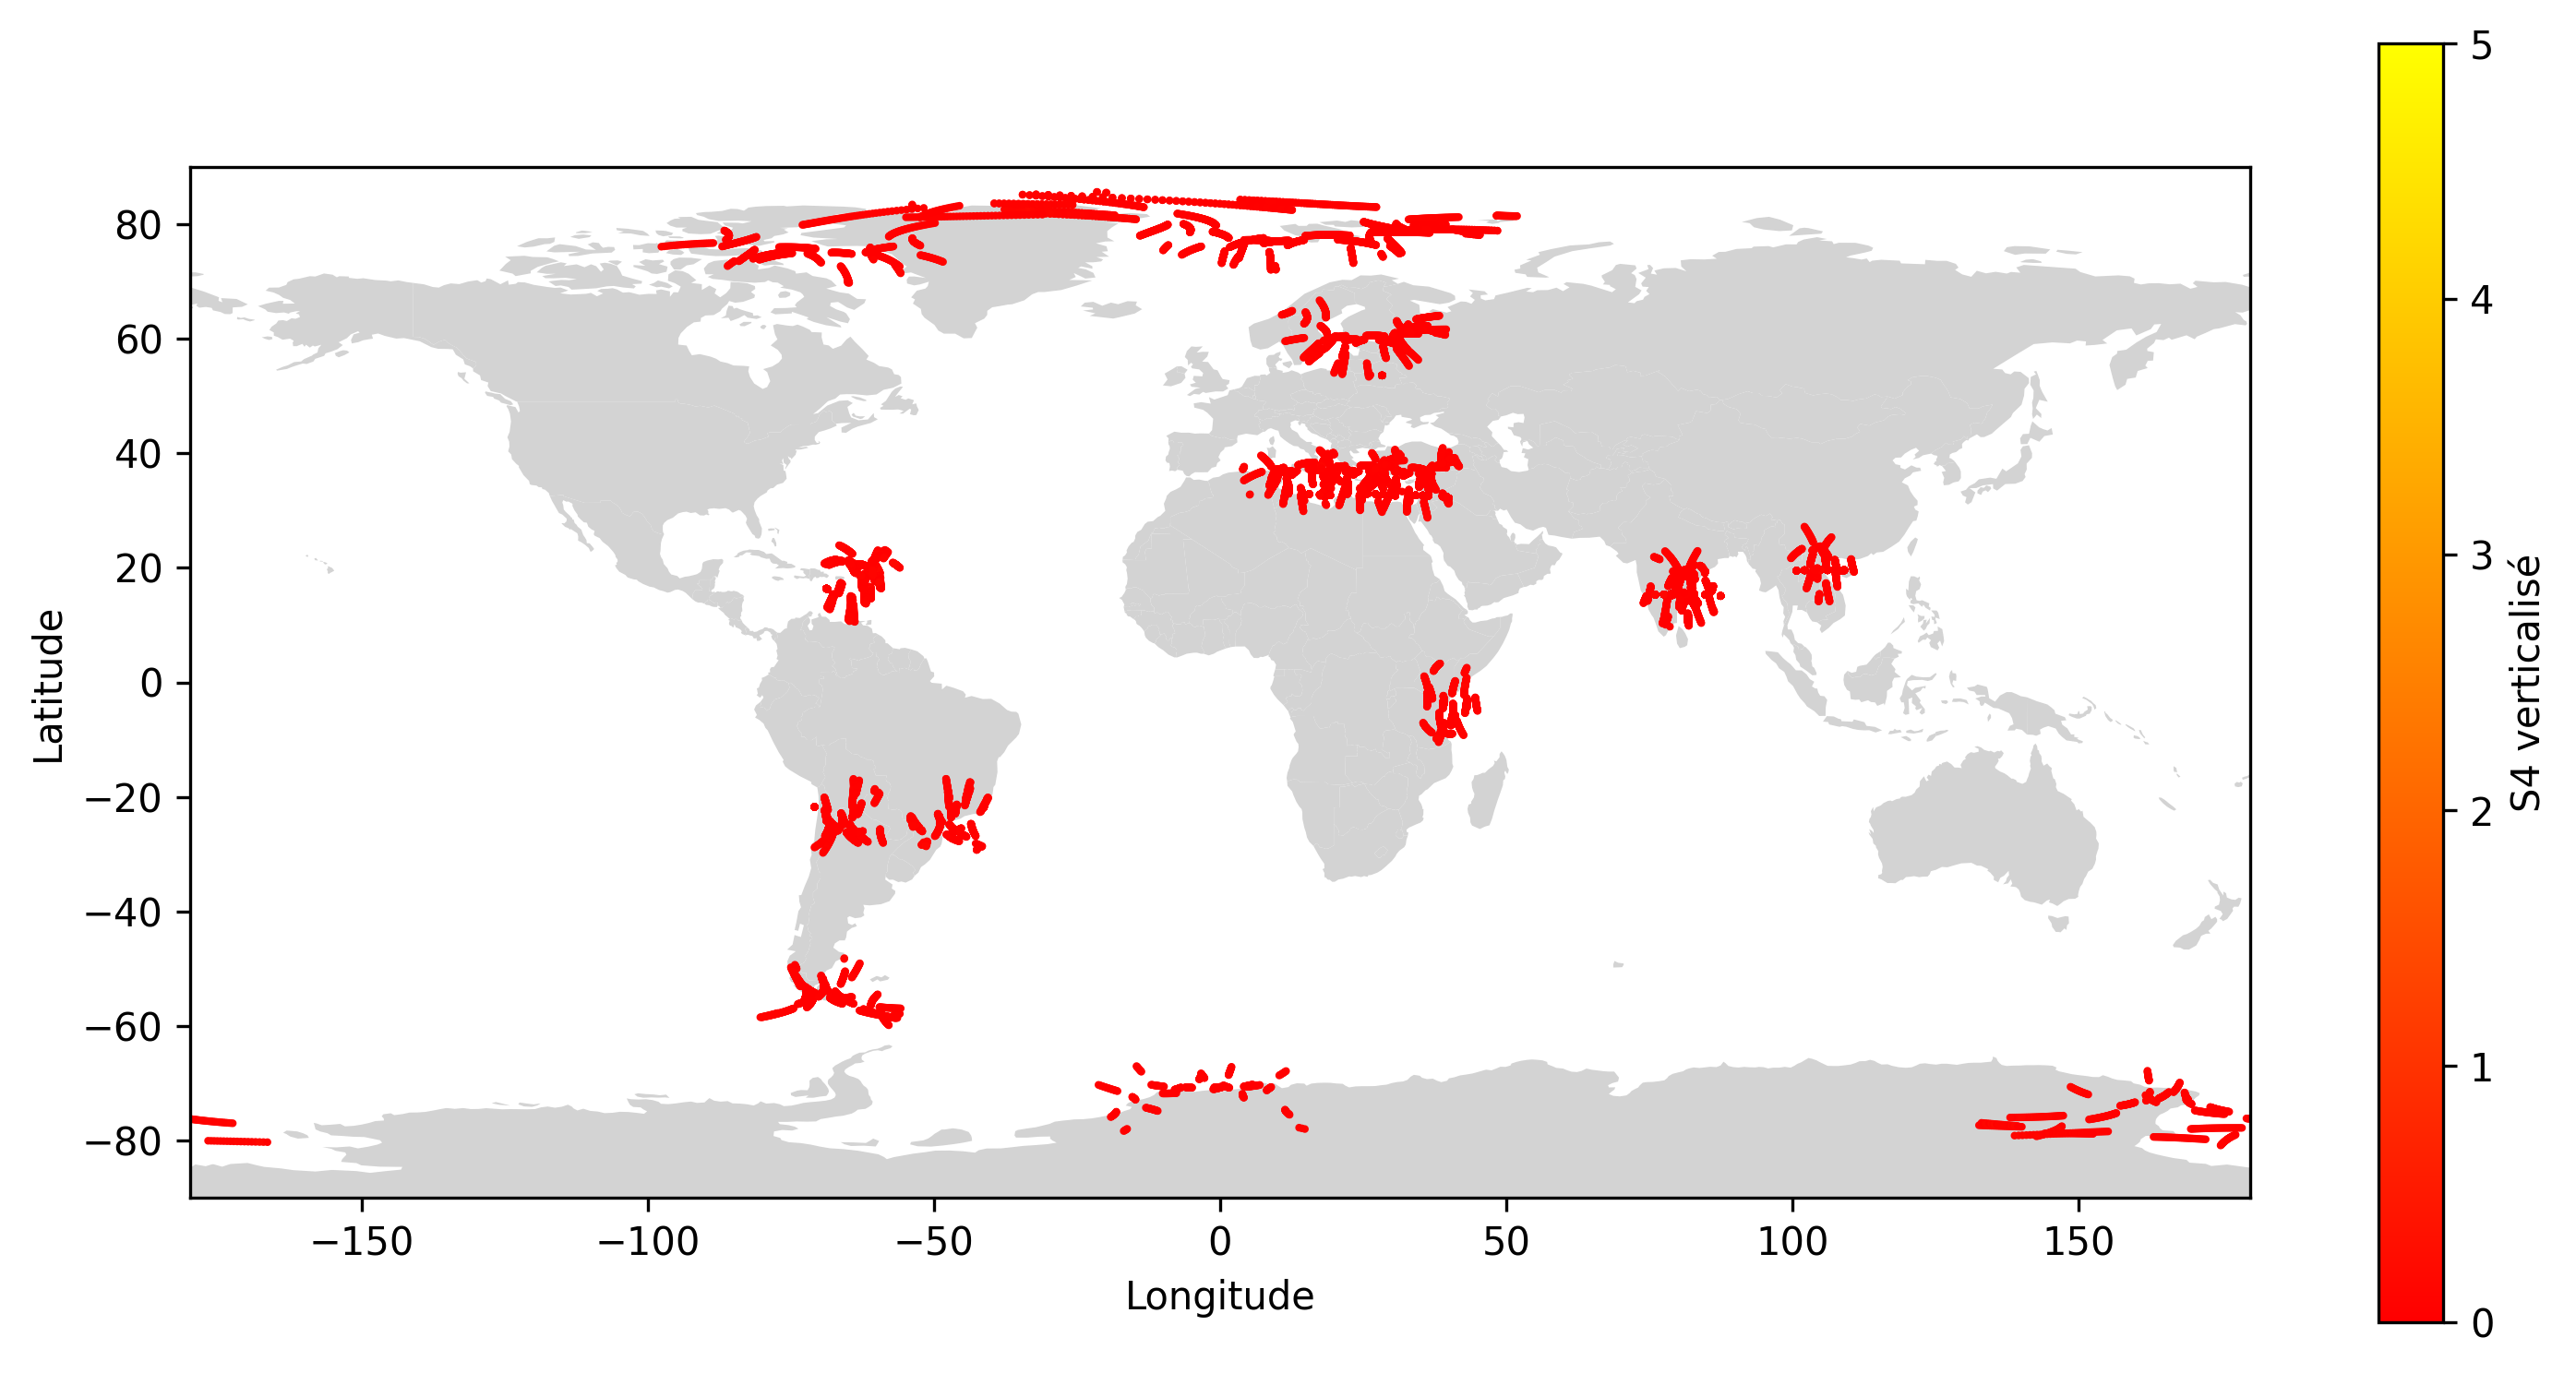

In [107]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6),dpi=300)
worldmap.plot(color="lightgrey", ax=ax)
# Plotting our Impact Energy data with a color map
x = df['ipp_lon']
y = df['ipp_lat']
z = df['s4_l1_vert']
plt.scatter(x, y, s=1, c=z, alpha=1, vmin=0, vmax=5,
            cmap='autumn')
plt.colorbar(label='S4 verticalisé')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

#first_year = df["Datetime"].min().strftime("%Y")
#last_year = df["Datetime"].max().strftime("%Y")
#plt.title("NASA: Fireballs Reported by Government Sensors\n" +
 #         str(first_year) + " - " + str(last_year))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()